In [1]:
from text3d2video.artifacts.animation_artifact import AnimationArtifact

anim_tag = "cat_rotation_90:latest"
animation = AnimationArtifact.from_wandb_artifact_tag(anim_tag, download=True)

frames = animation.frame_nums(5)
cameras = animation.cameras(frames)
meshes = animation.load_frames(frames)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   2 of 2 files downloaded.  


In [ ]:
from text3d2video.artifacts.animation_artifact import AnimationArtifact

anim_tag = "cat_rotation_90:latest"
animation = AnimationArtifact.from_wandb_artifact_tag(anim_tag, download=True)

frames = animation.frame_nums(5)
cameras = animation.cameras(frames)
meshes = animation.load_frames(frames)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   2 of 2 files downloaded.  


In [1]:
from text3d2video.artifacts.animation_artifact import AnimationArtifact

anim_tag = "cat_rotation_90:latest"
animation = AnimationArtifact.from_wandb_artifact_tag(anim_tag, download=True)

frames = animation.frame_nums(5)
cameras = animation.cameras(frames)
meshes = animation.load_frames(frames)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   2 of 2 files downloaded.  


In [2]:
import torch
from diffusers import ControlNetModel, DPMSolverMultistepScheduler
from text3d2video.pipelines.controlnet_pipeline import ControlNetPipeline
from text3d2video.ipython_utils import display_ims

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

dtype = torch.float16
device = torch.device("cuda")

controlnet = ControlNetModel.from_pretrained(
    controlnet_repo, torch_dtype=torch.float16
).to(device)

pipe = ControlNetPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
pipe.unet.down_blocks[0].attentions[0]

Transformer2DModel(
  (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
  (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
  (transformer_blocks): ModuleList(
    (0): BasicTransformerBlock(
      (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (attn1): Attention(
        (to_q): Linear(in_features=320, out_features=320, bias=False)
        (to_k): Linear(in_features=320, out_features=320, bias=False)
        (to_v): Linear(in_features=320, out_features=320, bias=False)
        (to_out): ModuleList(
          (0): Linear(in_features=320, out_features=320, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (attn2): Attention(
        (to_q): Linear(in_features=320, out_features=320, bias=False)
        (to_k): Linear(in_features=768, out_features=320, bias=False)
        (to_v): Linear(in_features=768, out_features=320, bias=False)
        (to_out): Modul

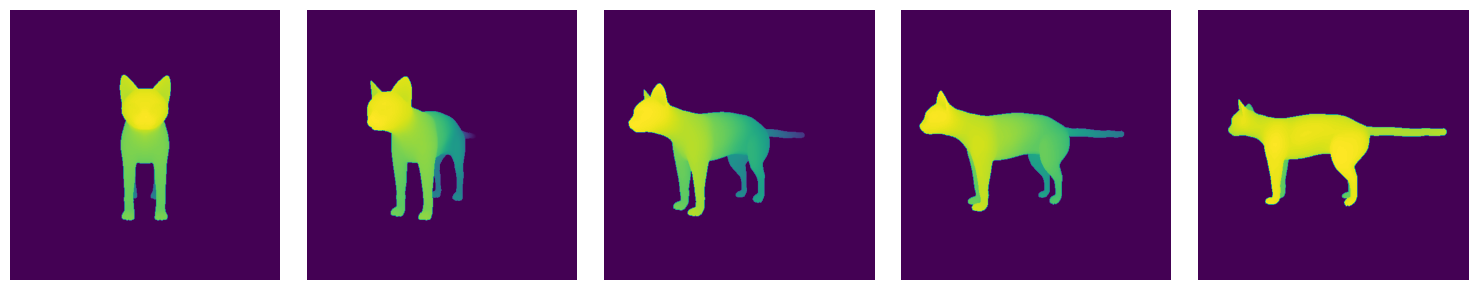

In [14]:
from text3d2video.rendering import render_depth_map

depth_maps = render_depth_map(meshes, cameras)
display_ims(depth_maps, 3)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


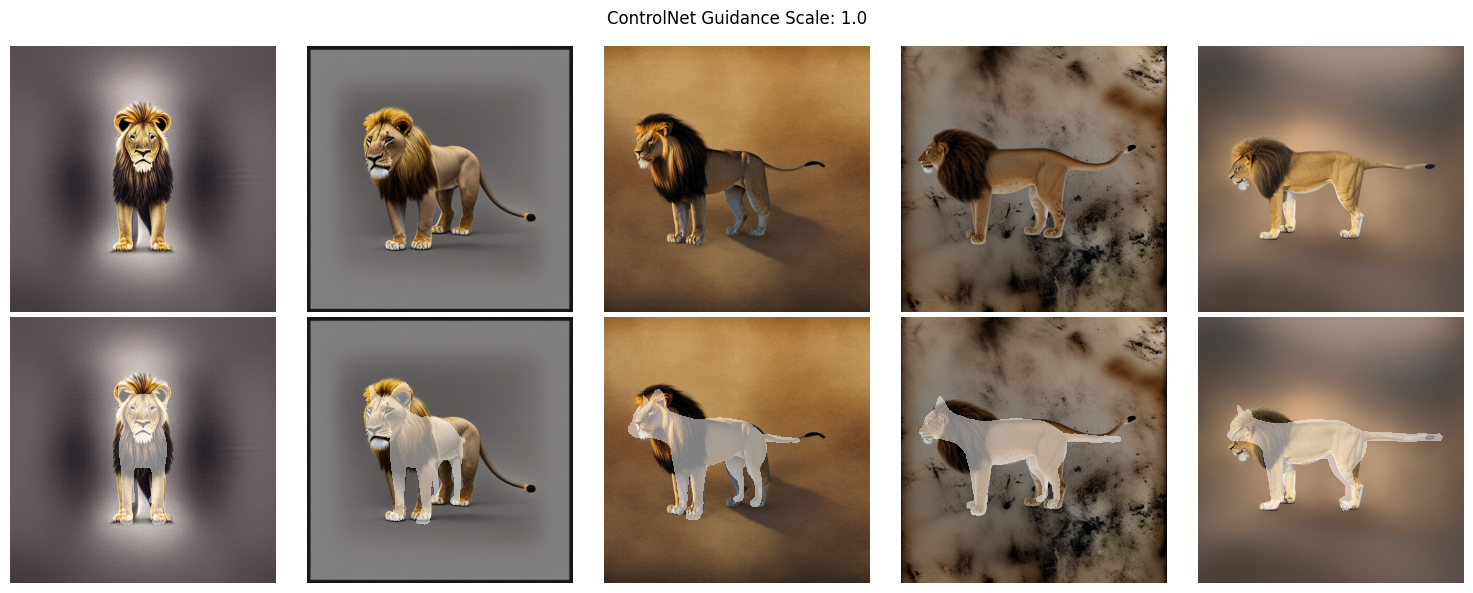

In [18]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from text3d2video.attn_processor import MultiFrameAttnProcessor, SaveConfig


def plot_images_and_depth(images, depths, scale=3, alpha=0.5, title=None):
    
    n_ims = len(images)
    transparent_cmap = ListedColormap(["none"] + ["white"] * 5)

    fig, axs = plt.subplots(2, n_ims, figsize=(scale * n_ims, 2 * scale))

    fig.suptitle(title)

    for i in range(n_ims):
        ax_im = axs[0, i]
        ax_im_depth = axs[1, i]
        ax_im.imshow(images[i])
        ax_im_depth.imshow(images[i])
        ax_im_depth.imshow(depths[i], cmap=transparent_cmap, alpha=alpha)
        ax_im.axis("off")
        ax_im_depth.axis("off")

    plt.tight_layout()


attn_processor = MultiFrameAttnProcessor(pipe.unet)

def pre_step(t, i):
    attn_processor.cur_timestep = t
    attn_processor.cur_timestep_idx = i

save_cfg = SaveConfig()
save_cfg.save_steps = []
save_cfg.module_pahts = []
attn_processor.save_cfg = save_cfg

pipe.pre_step_callback = pre_step
# pipe.unet.set_attn_processor(attn_processor)

attn_processor.attend_to_self = False
attn_processor.target_frame_indices = [0,1,2,3,4]

controlnet_guidance_scale = 1.0
gen = torch.Generator(device=device)
gen.manual_seed(2)

prompt = "Lion"
n = len(depth_maps)
images = pipe(
    [prompt] * n,
    depth_maps,
    guess_mode=True,
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=controlnet_guidance_scale,
    generator=gen,
)

plot_images_and_depth(images, depth_maps, scale=3, title=f"ControlNet Guidance Scale: {controlnet_guidance_scale}")

In [33]:
guidance_scales = [0.7, 1, 2, 3]

ims_scales = []

for controlnet_guidance_scale in guidance_scales:

    gen = torch.Generator(device=device)
    gen.manual_seed(3)

    prompt = "Lion"
    n = len(depth_maps)
    images = pipe(
        [prompt] * n,
        depth_maps,
        guess_mode=True,
        num_inference_steps=10,
        guidance_scale=7.5,
        controlnet_conditioning_scale=controlnet_guidance_scale,
        generator=gen,
    )
    ims_scales.append(images)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


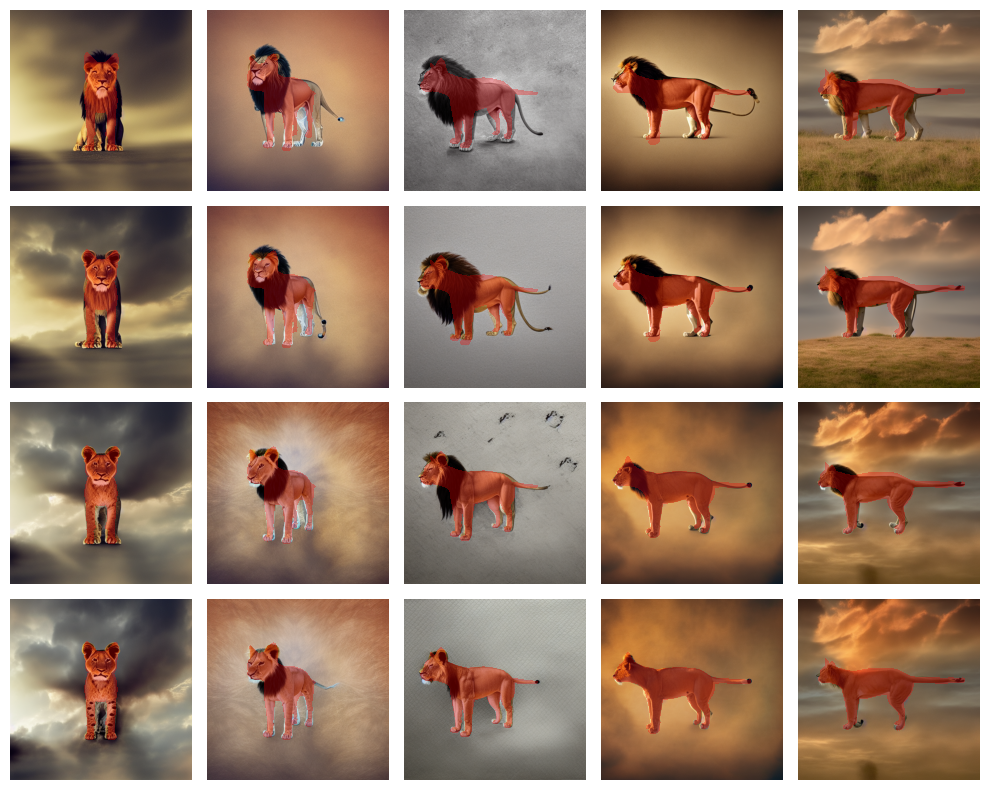

In [34]:
n_ims = len(ims_scales[0])
n_rows = len(ims_scales)
transparent_cmap = ListedColormap(["none"] + ["red"] * 5)

scale = 2
alpha = 0.3 

fig, axs = plt.subplots(n_rows, n_ims, figsize=(scale * n_ims, scale * n_rows))

for row_i in range(n_rows):
    for image_i in range(n_ims):
        image = ims_scales[row_i][image_i]
        depth = depth_maps[image_i]
        ax = axs[row_i, image_i]
        ax.imshow(image)
        ax.imshow(depth, cmap=transparent_cmap, alpha=alpha)
        ax.axis("off")

plt.tight_layout()